In [22]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.parametrizations import spectral_norm
from torch.autograd import Variable
from torchvision import datasets, transforms, utils
import seaborn as sns
import matplotlib.pyplot as plt
from torchsummary import summary
from dataTransformation import labels4clients, distribute_data_labels4clients
from gan_model import Discriminator, Generator, initialize_weights
from network import Server, Worker
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from utils import Logger
from fid_score import *
from inception import *
import math

In [23]:
NUM_WORKERS = 5
CLASSES_PER_USER = 10
NUM_EPOCHS = 200

LEARNING_RATE = 2e-4
B1 = 0.5
B2 = 0.999
BATCH_SIZE = 16
NOISE_DIM = 128
FID_BATCH_SIZE = 20
NUM_UNIQUE_USERS = NUM_WORKERS

In [24]:
num_classes = 10
logger = Logger(model_name='F2U',data_name='CIFAR10')
dictionary = labels4clients(num_classes,CLASSES_PER_USER,NUM_WORKERS,NUM_UNIQUE_USERS,random_seed=False)
print(dictionary)

{0: [0, 1, 2, 3, 4], 1: [0, 1, 2, 3, 4], 2: [0, 1, 2, 3, 4], 3: [0, 1, 2, 3, 4], 4: [0, 1, 2, 3, 4], 5: [0, 1, 2, 3, 4], 6: [0, 1, 2, 3, 4], 7: [0, 1, 2, 3, 4], 8: [0, 1, 2, 3, 4], 9: [0, 1, 2, 3, 4]}


In [25]:
trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# trans_cifar = transforms.Compose([transforms.ToTensor()])
dataset = datasets.CIFAR10(root='./datasets/cifar/', train=True, download=True, transform=trans_cifar)
dataset_test = datasets.CIFAR10(root='./datasets/cifar/', train=False, download=True, transform=trans_cifar)
dataloader_one = torch.utils.data.DataLoader(dataset, shuffle = True,batch_size=BATCH_SIZE)
dataloader_test = torch.utils.data.DataLoader(dataset_test, shuffle = True,batch_size=10000)

Files already downloaded and verified
Files already downloaded and verified


In [26]:
for img in dataloader_test:
    test_imgs=img[0].to(dev)

In [27]:
# print(dataset.data[0])
# print(dataset.transforms(dataset.data[0],transforms.ToTensor()))
# print(dataset.transforms(dataset.data[0],trans_cifar))

transformed shape: (3, 32, 32)


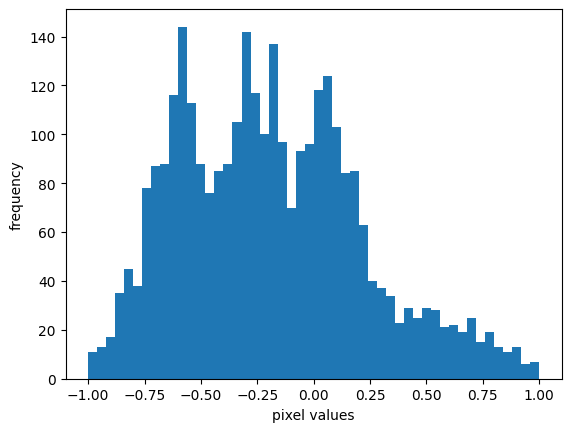

In [28]:
transformed = trans_cifar(dataset.data[0]).cpu().detach().numpy()
print("transformed shape:", transformed.shape)
plt.figure('normalized data')
plt.hist(transformed.ravel(), bins=50, density=False)
plt.xlabel("pixel values")
plt.ylabel("frequency")
plt.show()

In [29]:
# print(dataset.data.shape)
# print(type(dataset))
# print(dataloader_one.dataset.data.shape)
# x,_ = dataloader_one.dataset[0]
# print(x.shape)
# print(x)

In [30]:
x_train_normalized_np = np.empty((dataset.data.shape[0],dataset.data.shape[3],dataset.data.shape[1],dataset.data.shape[2]))
print("train datatset shape:",x_train_normalized_np.shape)
for i in range(len(dataset)):
    x_train_normalized_np[i] = trans_cifar(dataset.data[i])

train datatset shape: (50000, 3, 32, 32)


In [31]:
x_train_normalized_np[0][0].shape

(32, 32)

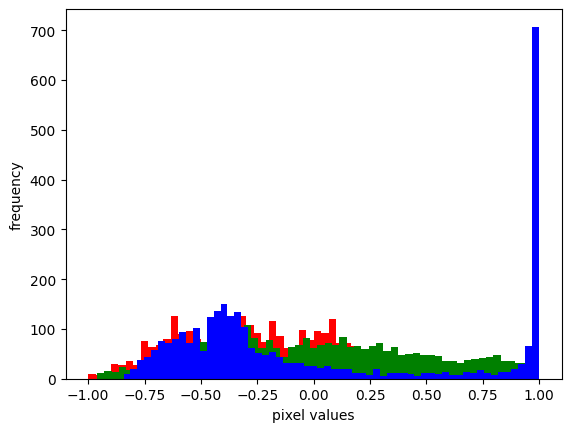

In [32]:
plt.figure('normalized data')
bin_size = 60
plt.hist(x_train_normalized_np[:][0].ravel(),color='r', bins=bin_size, density=False)
plt.hist(x_train_normalized_np[:][1].ravel(),color='g', bins=bin_size, density=False)
plt.hist(x_train_normalized_np[:][2].ravel(),color='b', bins=bin_size, density=False)
plt.xlabel("pixel values")
plt.ylabel("frequency")
plt.show()

In [33]:
# x_train = np.asarray(dataset.data)
y_train = np.asarray(dataset.targets)
x_clinet_list, y_client_list = distribute_data_labels4clients(x_train_normalized_np,y_train,dictionary,False)

In [34]:
def getDist(y,num_classes,user_num):
    ax = sns.countplot(x=y)
    ax.set(title="Count of data classes for %s" %user_num)
    plt.show()

10000


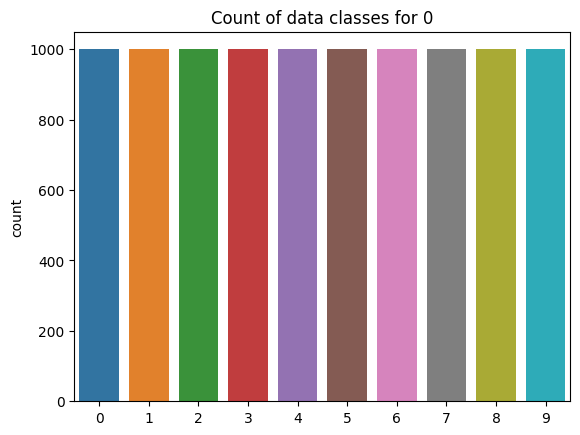

10000


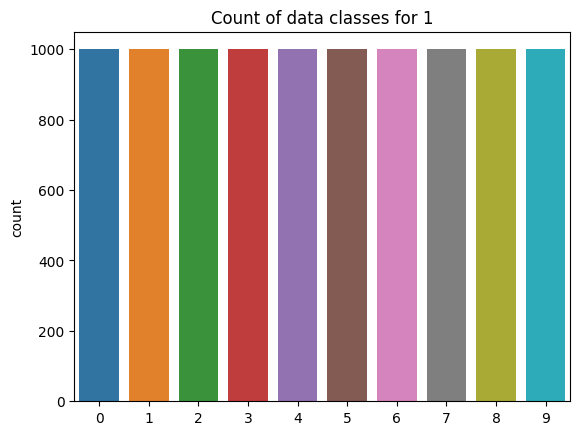

10000


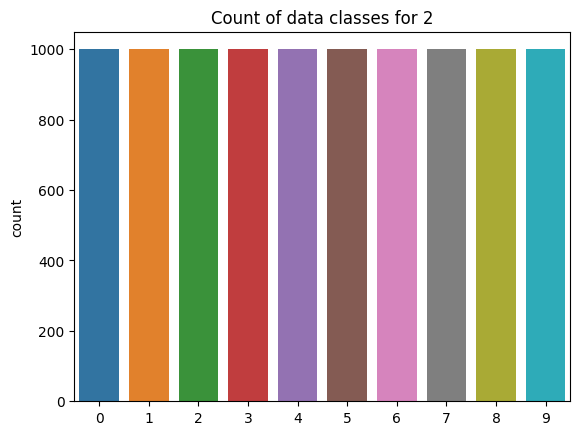

10000


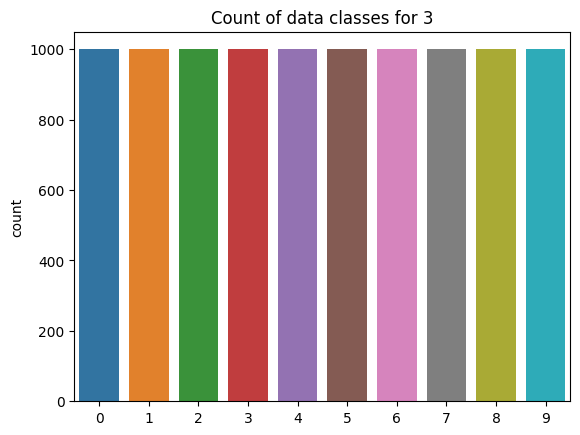

10000


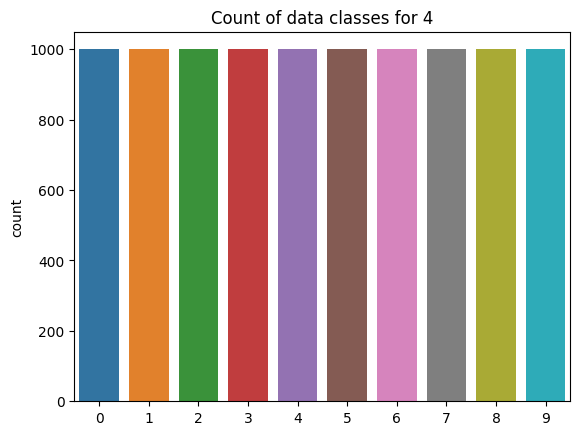

In [35]:
for i in range (len(x_clinet_list)):
    print(len(y_client_list[i]))
    getDist(y_client_list[i],num_classes,i)

In [36]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
dev = torch.device(dev)

In [37]:
fic_model = InceptionV3().to(dev)

In [38]:
main_server = Server(0,LEARNING_RATE,B1,B2)
main_server.generator.train()
workers = []
for i in range(NUM_WORKERS):
    worker = Worker(i,LEARNING_RATE,B1,B2)
    # x_clinet_list[i] = np.transpose(x_clinet_list[i],(0, 3, 1, 2))
    worker.load_worker_data(x_clinet_list[i], y_client_list[i])
    worker.discriminator.train()
    workers.append(worker)
    
# summary(main_server.generator,(128,1,1))
# summary(workers[0].discriminator,(3,32,32))

In [39]:
criterion = nn.MSELoss()
fixed_noise = torch.randn(36, NOISE_DIM, 1, 1).to(dev)

worker_loaders = []

for worker in workers:
    # print(worker.x_data.shape)
    worker_loaders.append([])
    for batch_id, real in enumerate(DataLoader(dataset=worker.x_data,batch_size=BATCH_SIZE)):
        worker_loaders[-1].append(real)

In [40]:
trial = False

In [41]:
# GAN archicture trial (trial == TRUE)
if trial:
    start = 0
    end = start + NUM_EPOCHS
    for epoch in range(start,end):
        for i, data in enumerate(dataloader_one):
            worker = workers[0]
            noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
            fake = main_server.generator(noise)
            real, _ = data

            ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
            
            current_disc_real = worker.discriminator(real).reshape(-1)
            # print('current discriminator real output', current_disc_real)
            worker.loss_disc_real = criterion(current_disc_real, torch.ones_like(current_disc_real))
            # print('worker loss_disc_real output', current_disc_real)
            current_disc_fake = worker.discriminator(fake.detach()).reshape(-1)
            worker.loss_disc_fake = criterion(current_disc_fake, torch.zeros_like(current_disc_fake))
            worker.loss_disc = (worker.loss_disc_real + worker.loss_disc_fake) / 2
            worker.discriminator.zero_grad()
            worker.loss_disc.backward()
            # total_norm_d =0
            # for p in list(filter(lambda p: p.grad is not None, worker.discriminator.parameters())):
            #     total_norm_d += p.grad.detach().data.norm(2).item()** 2
            # total_norm_d = total_norm_d ** 0.5

            worker.d_optimizer.step()

            ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
            
            output = worker.discriminator(fake).reshape(-1)
            main_server.loss_gen = criterion(output, torch.ones_like(output))
            main_server.generator.zero_grad()
            main_server.loss_gen.backward()

            # total_norm_g =0
            # for p in list(filter(lambda p: p.grad is not None, main_server.generator.parameters())):
            #     total_norm_g += p.grad.detach().data.norm(2).item()** 2
            # total_norm_g = total_norm_g ** 0.5

            main_server.g_optimizer.step()


            logger.log(worker.loss_disc.item(),main_server.loss_gen.item(),worker.loss_disc_real, worker.loss_disc_fake,epoch,i,len(dataloader_one))

            # Print loss
            if i % 100 == 0:    
                fid_z = torch.randn(FID_BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
                gen_imgs = main_server.generator(fid_z.detach())
                mu_gen, sigma_gen = calculate_activation_statistics(gen_imgs, fic_model, batch_size=FID_BATCH_SIZE,cuda=True)
                mu_test, sigma_test = calculate_activation_statistics(test_imgs[:FID_BATCH_SIZE], fic_model, batch_size=FID_BATCH_SIZE,cuda=True)
                fid = calculate_frechet_distance(mu_gen, sigma_gen, mu_test, sigma_test)
                logger.log_fid(fid,epoch,i,len(dataloader_one))

                print(
                    f"Epoch [{epoch}/{end}] Batch {i}/{len(dataloader_one)} \
                    Loss D: {worker.loss_disc:.4f}, loss G: {main_server.loss_gen:.4f}, FID Score: {fid:.1f}"
                )

            if i% 500 == 0:
                with torch.no_grad():
                    fake = main_server.generator(fixed_noise)
                    logger.log_images(fake,len(fake), epoch, i, len(dataloader_one))
        if epoch % 50 == 0 and epoch !=0:
            logger.save_models(main_server,workers,epoch)


Epoch [0/200] Batch 0/625                     Loss D: 0.4986, loss G: 0.7250, FID Score: 405.7
Epoch [0/200] Batch 100/625                     Loss D: 0.0726, loss G: 0.7303, FID Score: 401.5
Epoch [0/200] Batch 200/625                     Loss D: 0.2875, loss G: 0.9897, FID Score: 375.6
Epoch [0/200] Batch 300/625                     Loss D: 0.2630, loss G: 0.6413, FID Score: 383.7
Epoch [0/200] Batch 400/625                     Loss D: 0.2310, loss G: 0.7375, FID Score: 394.4
Epoch [0/200] Batch 500/625                     Loss D: 0.1413, loss G: 0.1193, FID Score: 390.9
Epoch [0/200] Batch 600/625                     Loss D: 0.1063, loss G: 0.6640, FID Score: 427.8
Epoch [1/200] Batch 0/625                     Loss D: 0.2426, loss G: 1.0193, FID Score: 322.6
Epoch [1/200] Batch 100/625                     Loss D: 0.1823, loss G: 0.7226, FID Score: 319.6
Epoch [1/200] Batch 200/625                     Loss D: 0.1669, loss G: 0.7081, FID Score: 293.3
Epoch [1/200] Batch 300/625       

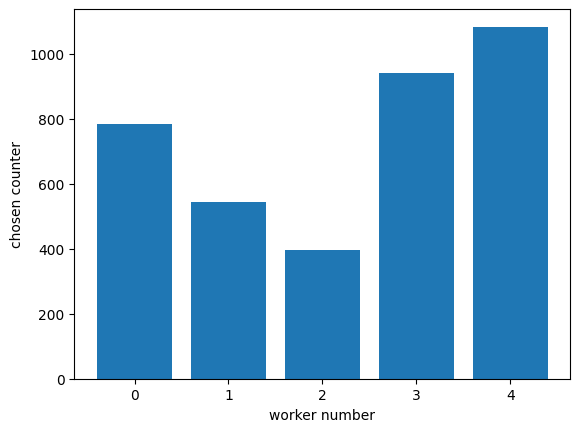

Epoch [6/200] Batch 0/625                     Loss D: 0.1577, loss G: 0.5263, FID Score: 249.5
Epoch [6/200] Batch 100/625                     Loss D: 0.0930, loss G: 0.6218, FID Score: 221.8
Epoch [6/200] Batch 200/625                     Loss D: 0.1181, loss G: 0.4356, FID Score: 243.3
Epoch [6/200] Batch 300/625                     Loss D: 0.0970, loss G: 0.5160, FID Score: 260.2
Epoch [6/200] Batch 400/625                     Loss D: 0.1710, loss G: 0.8760, FID Score: 223.5
Epoch [6/200] Batch 500/625                     Loss D: 0.1493, loss G: 0.8602, FID Score: 244.7
Epoch [6/200] Batch 600/625                     Loss D: 0.0870, loss G: 0.4835, FID Score: 215.5
Epoch [7/200] Batch 0/625                     Loss D: 0.1132, loss G: 0.7515, FID Score: 234.8
Epoch [7/200] Batch 100/625                     Loss D: 0.0949, loss G: 0.7809, FID Score: 246.7
Epoch [7/200] Batch 200/625                     Loss D: 0.1192, loss G: 0.6757, FID Score: 230.5
Epoch [7/200] Batch 300/625       

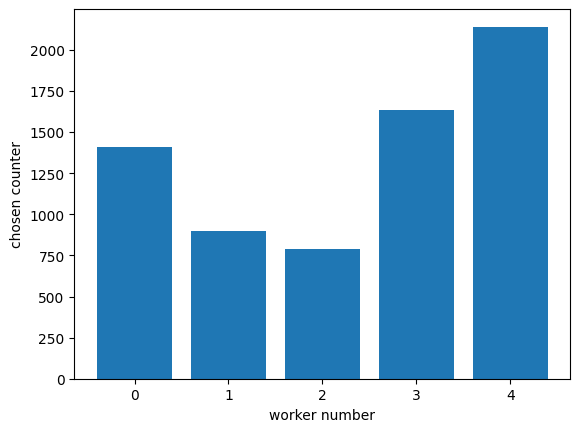

Epoch [11/200] Batch 0/625                     Loss D: 0.1555, loss G: 0.5516, FID Score: 245.0
Epoch [11/200] Batch 100/625                     Loss D: 0.1334, loss G: 0.7296, FID Score: 233.2
Epoch [11/200] Batch 200/625                     Loss D: 0.1191, loss G: 0.4945, FID Score: 233.3
Epoch [11/200] Batch 300/625                     Loss D: 0.0820, loss G: 0.8844, FID Score: 227.7
Epoch [11/200] Batch 400/625                     Loss D: 0.1546, loss G: 0.6145, FID Score: 228.7
Epoch [11/200] Batch 500/625                     Loss D: 0.2634, loss G: 0.9767, FID Score: 231.5
Epoch [11/200] Batch 600/625                     Loss D: 0.1287, loss G: 0.3899, FID Score: 228.4
Epoch [12/200] Batch 0/625                     Loss D: 0.0787, loss G: 0.7462, FID Score: 231.5
Epoch [12/200] Batch 100/625                     Loss D: 0.0832, loss G: 0.7599, FID Score: 231.9
Epoch [12/200] Batch 200/625                     Loss D: 0.0741, loss G: 0.7804, FID Score: 239.4
Epoch [12/200] Batch 300

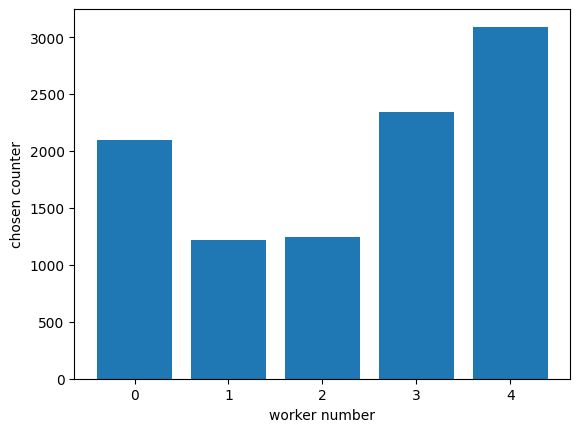

Epoch [16/200] Batch 0/625                     Loss D: 0.1204, loss G: 0.7066, FID Score: 247.7
Epoch [16/200] Batch 100/625                     Loss D: 0.1468, loss G: 0.5491, FID Score: 245.7
Epoch [16/200] Batch 200/625                     Loss D: 0.1582, loss G: 0.7827, FID Score: 238.1
Epoch [16/200] Batch 300/625                     Loss D: 0.1303, loss G: 0.4860, FID Score: 241.9
Epoch [16/200] Batch 400/625                     Loss D: 0.1096, loss G: 0.7377, FID Score: 227.1
Epoch [16/200] Batch 500/625                     Loss D: 0.1403, loss G: 0.5549, FID Score: 230.3
Epoch [16/200] Batch 600/625                     Loss D: 0.1137, loss G: 0.3882, FID Score: 219.8
Epoch [17/200] Batch 0/625                     Loss D: 0.0929, loss G: 0.6463, FID Score: 230.0
Epoch [17/200] Batch 100/625                     Loss D: 0.1243, loss G: 0.7854, FID Score: 243.7
Epoch [17/200] Batch 200/625                     Loss D: 0.1458, loss G: 0.6782, FID Score: 224.1
Epoch [17/200] Batch 300

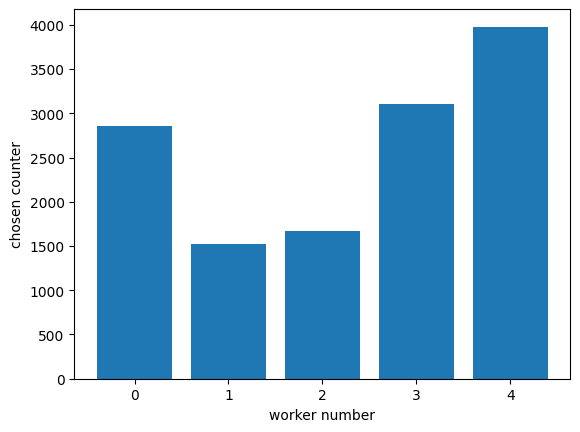

Epoch [21/200] Batch 0/625                     Loss D: 0.1114, loss G: 0.6076, FID Score: 246.5
Epoch [21/200] Batch 100/625                     Loss D: 0.1451, loss G: 0.7449, FID Score: 248.6
Epoch [21/200] Batch 200/625                     Loss D: 0.1090, loss G: 0.7272, FID Score: 230.5
Epoch [21/200] Batch 300/625                     Loss D: 0.0894, loss G: 0.5531, FID Score: 216.4
Epoch [21/200] Batch 400/625                     Loss D: 0.2100, loss G: 0.6056, FID Score: 233.0
Epoch [21/200] Batch 500/625                     Loss D: 0.1112, loss G: 0.6819, FID Score: 251.8
Epoch [21/200] Batch 600/625                     Loss D: 0.1984, loss G: 0.3307, FID Score: 219.1
Epoch [22/200] Batch 0/625                     Loss D: 0.1080, loss G: 0.5432, FID Score: 227.0
Epoch [22/200] Batch 100/625                     Loss D: 0.1214, loss G: 0.6654, FID Score: 226.9
Epoch [22/200] Batch 200/625                     Loss D: 0.1503, loss G: 0.8638, FID Score: 229.7
Epoch [22/200] Batch 300

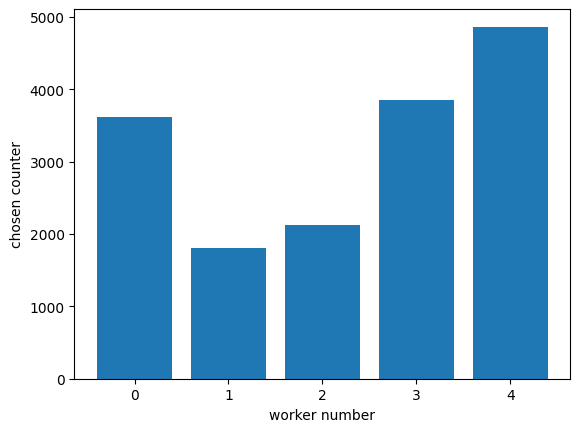

Epoch [26/200] Batch 0/625                     Loss D: 0.1133, loss G: 0.6386, FID Score: 226.0
Epoch [26/200] Batch 100/625                     Loss D: 0.1934, loss G: 0.4738, FID Score: 239.9
Epoch [26/200] Batch 200/625                     Loss D: 0.1234, loss G: 0.5398, FID Score: 242.7
Epoch [26/200] Batch 300/625                     Loss D: 0.1679, loss G: 0.4211, FID Score: 217.1
Epoch [26/200] Batch 400/625                     Loss D: 0.1210, loss G: 0.7292, FID Score: 231.2
Epoch [26/200] Batch 500/625                     Loss D: 0.1316, loss G: 0.4559, FID Score: 241.8
Epoch [26/200] Batch 600/625                     Loss D: 0.1223, loss G: 0.5635, FID Score: 230.9
Epoch [27/200] Batch 0/625                     Loss D: 0.1119, loss G: 0.6767, FID Score: 221.2
Epoch [27/200] Batch 100/625                     Loss D: 0.1208, loss G: 0.6608, FID Score: 219.2
Epoch [27/200] Batch 200/625                     Loss D: 0.2207, loss G: 0.5846, FID Score: 221.6
Epoch [27/200] Batch 300

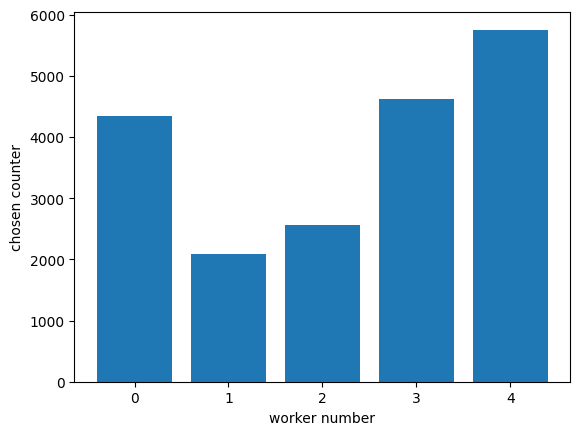

Epoch [31/200] Batch 0/625                     Loss D: 0.0804, loss G: 0.6380, FID Score: 236.4
Epoch [31/200] Batch 100/625                     Loss D: 0.1057, loss G: 0.8518, FID Score: 232.0
Epoch [31/200] Batch 200/625                     Loss D: 0.1515, loss G: 0.8597, FID Score: 230.3
Epoch [31/200] Batch 300/625                     Loss D: 0.1272, loss G: 0.7586, FID Score: 238.2
Epoch [31/200] Batch 400/625                     Loss D: 0.1383, loss G: 0.6148, FID Score: 240.9
Epoch [31/200] Batch 500/625                     Loss D: 0.1268, loss G: 0.6781, FID Score: 243.6
Epoch [31/200] Batch 600/625                     Loss D: 0.1210, loss G: 0.5578, FID Score: 219.2
Epoch [32/200] Batch 0/625                     Loss D: 0.1103, loss G: 0.4610, FID Score: 225.3
Epoch [32/200] Batch 100/625                     Loss D: 0.1217, loss G: 0.6360, FID Score: 219.1
Epoch [32/200] Batch 200/625                     Loss D: 0.1273, loss G: 0.7426, FID Score: 228.0
Epoch [32/200] Batch 300

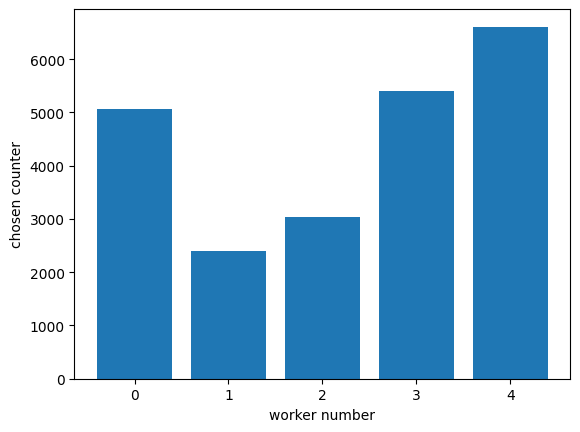

Epoch [36/200] Batch 0/625                     Loss D: 0.1084, loss G: 0.5808, FID Score: 236.5
Epoch [36/200] Batch 100/625                     Loss D: 0.1022, loss G: 0.7753, FID Score: 226.0
Epoch [36/200] Batch 200/625                     Loss D: 0.2509, loss G: 0.6837, FID Score: 241.3
Epoch [36/200] Batch 300/625                     Loss D: 0.1419, loss G: 0.6200, FID Score: 218.6
Epoch [36/200] Batch 400/625                     Loss D: 0.1231, loss G: 0.6908, FID Score: 236.0
Epoch [36/200] Batch 500/625                     Loss D: 0.0997, loss G: 0.6753, FID Score: 217.5
Epoch [36/200] Batch 600/625                     Loss D: 0.1043, loss G: 0.6693, FID Score: 218.2
Epoch [37/200] Batch 0/625                     Loss D: 0.1957, loss G: 0.4495, FID Score: 228.4
Epoch [37/200] Batch 100/625                     Loss D: 0.1527, loss G: 0.5047, FID Score: 228.6
Epoch [37/200] Batch 200/625                     Loss D: 0.1717, loss G: 0.6538, FID Score: 225.4
Epoch [37/200] Batch 300

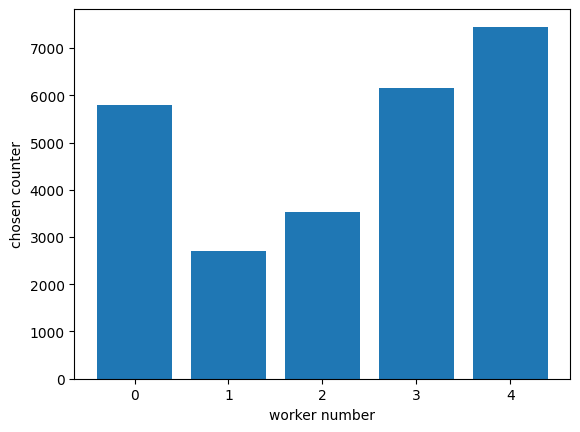

Epoch [41/200] Batch 0/625                     Loss D: 0.0996, loss G: 0.7408, FID Score: 222.7
Epoch [41/200] Batch 100/625                     Loss D: 0.1131, loss G: 0.8709, FID Score: 232.6
Epoch [41/200] Batch 200/625                     Loss D: 0.1085, loss G: 0.7052, FID Score: 214.4
Epoch [41/200] Batch 300/625                     Loss D: 0.1722, loss G: 0.4489, FID Score: 227.7
Epoch [41/200] Batch 400/625                     Loss D: 0.1163, loss G: 0.7397, FID Score: 232.1
Epoch [41/200] Batch 500/625                     Loss D: 0.1214, loss G: 0.4935, FID Score: 227.3
Epoch [41/200] Batch 600/625                     Loss D: 0.1245, loss G: 0.4816, FID Score: 235.9
Epoch [42/200] Batch 0/625                     Loss D: 0.1118, loss G: 0.5416, FID Score: 225.9
Epoch [42/200] Batch 100/625                     Loss D: 0.1138, loss G: 0.6720, FID Score: 231.7
Epoch [42/200] Batch 200/625                     Loss D: 0.1821, loss G: 0.4658, FID Score: 222.4
Epoch [42/200] Batch 300

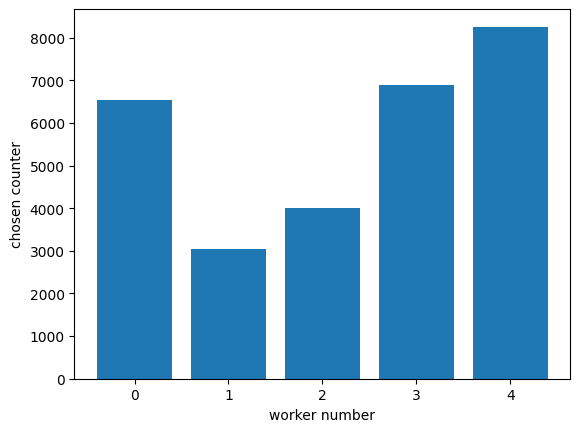

Epoch [46/200] Batch 0/625                     Loss D: 0.0924, loss G: 0.8111, FID Score: 216.2
Epoch [46/200] Batch 100/625                     Loss D: 0.0885, loss G: 0.6655, FID Score: 222.9
Epoch [46/200] Batch 200/625                     Loss D: 0.1402, loss G: 0.5220, FID Score: 226.1
Epoch [46/200] Batch 300/625                     Loss D: 0.1222, loss G: 0.4206, FID Score: 230.0
Epoch [46/200] Batch 400/625                     Loss D: 0.0786, loss G: 0.8066, FID Score: 221.1
Epoch [46/200] Batch 500/625                     Loss D: 0.1392, loss G: 0.4800, FID Score: 224.7
Epoch [46/200] Batch 600/625                     Loss D: 0.1473, loss G: 0.4160, FID Score: 218.6
Epoch [47/200] Batch 0/625                     Loss D: 0.0986, loss G: 0.6859, FID Score: 230.0
Epoch [47/200] Batch 100/625                     Loss D: 0.0933, loss G: 0.8084, FID Score: 246.7
Epoch [47/200] Batch 200/625                     Loss D: 0.1427, loss G: 0.6268, FID Score: 231.2
Epoch [47/200] Batch 300

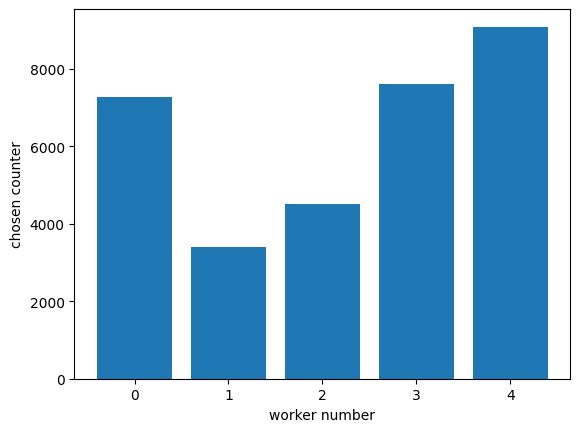

Epoch [51/200] Batch 0/625                     Loss D: 0.1081, loss G: 0.7514, FID Score: 224.3
Epoch [51/200] Batch 100/625                     Loss D: 0.1643, loss G: 0.6756, FID Score: 220.2
Epoch [51/200] Batch 200/625                     Loss D: 0.1922, loss G: 0.5111, FID Score: 234.8
Epoch [51/200] Batch 300/625                     Loss D: 0.1460, loss G: 0.3793, FID Score: 223.5
Epoch [51/200] Batch 400/625                     Loss D: 0.0963, loss G: 0.6486, FID Score: 227.4
Epoch [51/200] Batch 500/625                     Loss D: 0.0911, loss G: 0.6398, FID Score: 231.8
Epoch [51/200] Batch 600/625                     Loss D: 0.1954, loss G: 0.4388, FID Score: 231.0
Epoch [52/200] Batch 0/625                     Loss D: 0.0695, loss G: 0.7324, FID Score: 221.0
Epoch [52/200] Batch 100/625                     Loss D: 0.0930, loss G: 0.7500, FID Score: 228.1
Epoch [52/200] Batch 200/625                     Loss D: 0.0543, loss G: 0.8796, FID Score: 221.0
Epoch [52/200] Batch 300

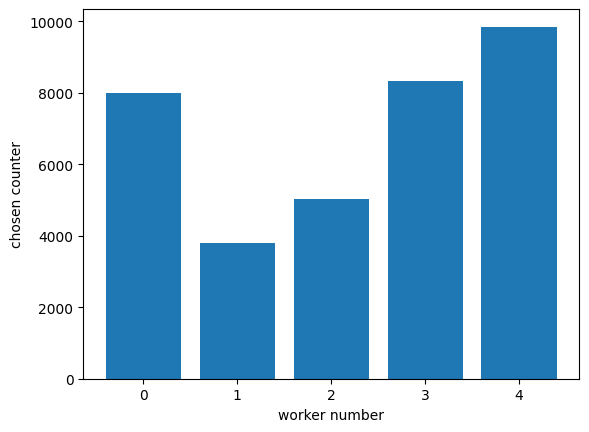

Epoch [56/200] Batch 0/625                     Loss D: 0.0865, loss G: 0.7672, FID Score: 232.8
Epoch [56/200] Batch 100/625                     Loss D: 0.0786, loss G: 0.6805, FID Score: 218.0
Epoch [56/200] Batch 200/625                     Loss D: 0.1804, loss G: 0.5671, FID Score: 243.4
Epoch [56/200] Batch 300/625                     Loss D: 0.0745, loss G: 0.7125, FID Score: 220.9
Epoch [56/200] Batch 400/625                     Loss D: 0.0937, loss G: 0.7703, FID Score: 236.8
Epoch [56/200] Batch 500/625                     Loss D: 0.0649, loss G: 0.9367, FID Score: 226.4
Epoch [56/200] Batch 600/625                     Loss D: 0.1047, loss G: 0.7395, FID Score: 233.3
Epoch [57/200] Batch 0/625                     Loss D: 0.2112, loss G: 0.3727, FID Score: 219.9
Epoch [57/200] Batch 100/625                     Loss D: 0.1631, loss G: 0.3431, FID Score: 209.5
Epoch [57/200] Batch 200/625                     Loss D: 0.1231, loss G: 0.5632, FID Score: 234.0
Epoch [57/200] Batch 300

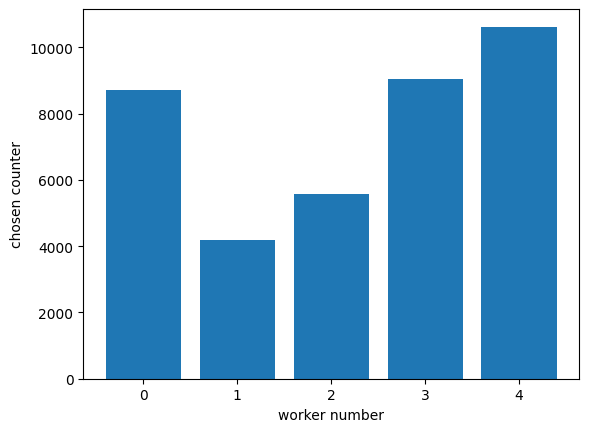

Epoch [61/200] Batch 0/625                     Loss D: 0.0764, loss G: 0.6066, FID Score: 232.6
Epoch [61/200] Batch 100/625                     Loss D: 0.0884, loss G: 0.7453, FID Score: 235.1
Epoch [61/200] Batch 200/625                     Loss D: 0.1142, loss G: 0.6707, FID Score: 224.4
Epoch [61/200] Batch 300/625                     Loss D: 0.0908, loss G: 0.6771, FID Score: 228.5
Epoch [61/200] Batch 400/625                     Loss D: 0.0874, loss G: 0.8074, FID Score: 226.0
Epoch [61/200] Batch 500/625                     Loss D: 0.0482, loss G: 0.8699, FID Score: 234.7
Epoch [61/200] Batch 600/625                     Loss D: 0.0702, loss G: 0.7291, FID Score: 230.1
Epoch [62/200] Batch 0/625                     Loss D: 0.0766, loss G: 0.7209, FID Score: 222.8
Epoch [62/200] Batch 100/625                     Loss D: 0.0681, loss G: 0.8169, FID Score: 242.0
Epoch [62/200] Batch 200/625                     Loss D: 0.1322, loss G: 0.5782, FID Score: 219.5
Epoch [62/200] Batch 300

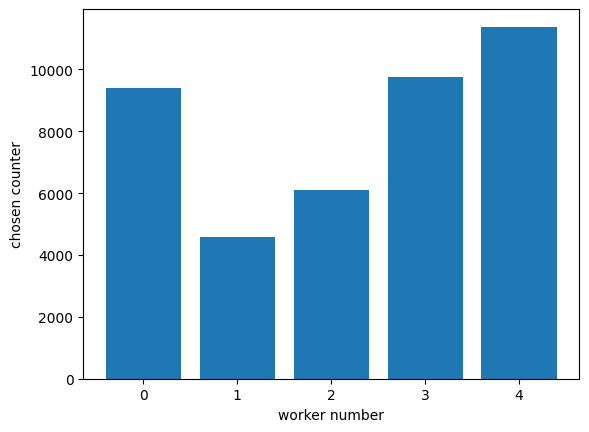

Epoch [66/200] Batch 0/625                     Loss D: 0.1173, loss G: 0.5452, FID Score: 222.1
Epoch [66/200] Batch 100/625                     Loss D: 0.0529, loss G: 0.8218, FID Score: 221.4
Epoch [66/200] Batch 200/625                     Loss D: 0.0763, loss G: 0.8073, FID Score: 223.7
Epoch [66/200] Batch 300/625                     Loss D: 0.1035, loss G: 0.5475, FID Score: 237.3
Epoch [66/200] Batch 400/625                     Loss D: 0.0896, loss G: 0.7640, FID Score: 220.8
Epoch [66/200] Batch 500/625                     Loss D: 0.0645, loss G: 0.7892, FID Score: 233.2
Epoch [66/200] Batch 600/625                     Loss D: 0.1447, loss G: 0.2841, FID Score: 230.2
Epoch [67/200] Batch 0/625                     Loss D: 0.0945, loss G: 0.5602, FID Score: 229.1
Epoch [67/200] Batch 100/625                     Loss D: 0.0668, loss G: 0.6807, FID Score: 221.9
Epoch [67/200] Batch 200/625                     Loss D: 0.0666, loss G: 0.7031, FID Score: 223.0
Epoch [67/200] Batch 300

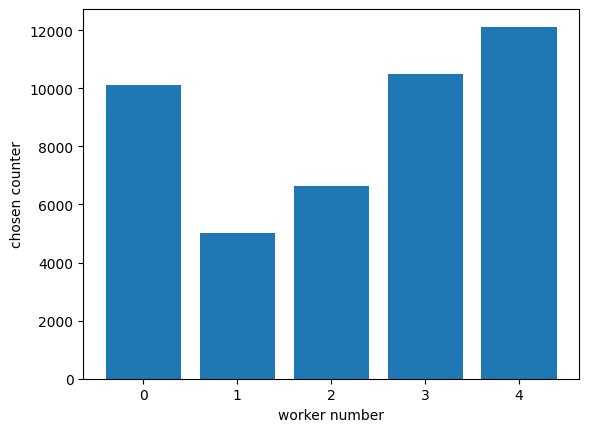

Epoch [71/200] Batch 0/625                     Loss D: 0.0620, loss G: 0.8123, FID Score: 216.9
Epoch [71/200] Batch 100/625                     Loss D: 0.1696, loss G: 0.3707, FID Score: 217.9
Epoch [71/200] Batch 200/625                     Loss D: 0.1168, loss G: 0.4613, FID Score: 228.6
Epoch [71/200] Batch 300/625                     Loss D: 0.0989, loss G: 0.5648, FID Score: 227.5
Epoch [71/200] Batch 400/625                     Loss D: 0.0830, loss G: 0.7324, FID Score: 219.4
Epoch [71/200] Batch 500/625                     Loss D: 0.0749, loss G: 0.7942, FID Score: 225.3
Epoch [71/200] Batch 600/625                     Loss D: 0.1723, loss G: 0.3391, FID Score: 221.8
Epoch [72/200] Batch 0/625                     Loss D: 0.0678, loss G: 0.7016, FID Score: 218.7
Epoch [72/200] Batch 100/625                     Loss D: 0.0661, loss G: 0.8514, FID Score: 220.8
Epoch [72/200] Batch 200/625                     Loss D: 0.1220, loss G: 0.4709, FID Score: 230.7
Epoch [72/200] Batch 300

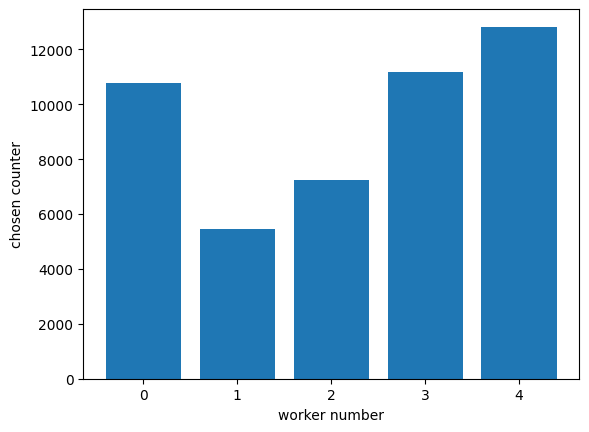

Epoch [76/200] Batch 0/625                     Loss D: 0.0973, loss G: 0.6498, FID Score: 226.0
Epoch [76/200] Batch 100/625                     Loss D: 0.1146, loss G: 0.5636, FID Score: 227.3
Epoch [76/200] Batch 200/625                     Loss D: 0.0920, loss G: 0.5554, FID Score: 236.0
Epoch [76/200] Batch 300/625                     Loss D: 0.0704, loss G: 0.8519, FID Score: 219.2
Epoch [76/200] Batch 400/625                     Loss D: 0.0933, loss G: 0.5440, FID Score: 221.1
Epoch [76/200] Batch 500/625                     Loss D: 0.2040, loss G: 0.5965, FID Score: 233.5
Epoch [76/200] Batch 600/625                     Loss D: 0.0708, loss G: 0.7126, FID Score: 232.2
Epoch [77/200] Batch 0/625                     Loss D: 0.1631, loss G: 0.3861, FID Score: 242.4
Epoch [77/200] Batch 100/625                     Loss D: 0.0700, loss G: 0.8507, FID Score: 226.4
Epoch [77/200] Batch 200/625                     Loss D: 0.1037, loss G: 0.4644, FID Score: 234.7
Epoch [77/200] Batch 300

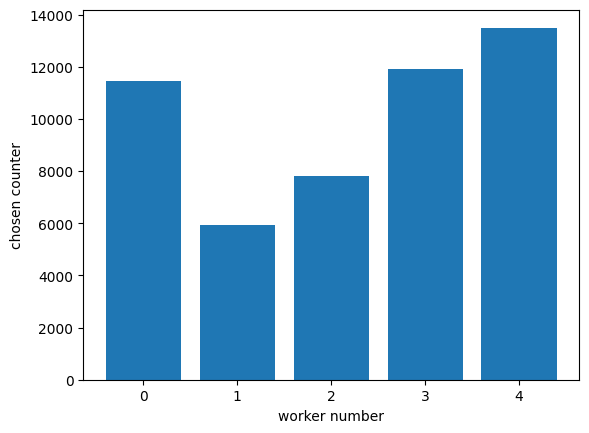

Epoch [81/200] Batch 0/625                     Loss D: 0.0724, loss G: 0.8103, FID Score: 234.2
Epoch [81/200] Batch 100/625                     Loss D: 0.0660, loss G: 0.7586, FID Score: 219.1
Epoch [81/200] Batch 200/625                     Loss D: 0.0496, loss G: 0.8319, FID Score: 216.5
Epoch [81/200] Batch 300/625                     Loss D: 0.1062, loss G: 0.5738, FID Score: 233.2
Epoch [81/200] Batch 400/625                     Loss D: 0.0824, loss G: 0.7367, FID Score: 236.2
Epoch [81/200] Batch 500/625                     Loss D: 0.0978, loss G: 0.7037, FID Score: 229.2
Epoch [81/200] Batch 600/625                     Loss D: 0.0472, loss G: 0.7220, FID Score: 229.4
Epoch [82/200] Batch 0/625                     Loss D: 0.1683, loss G: 0.3971, FID Score: 229.2
Epoch [82/200] Batch 100/625                     Loss D: 0.0921, loss G: 0.5258, FID Score: 223.1
Epoch [82/200] Batch 200/625                     Loss D: 0.0540, loss G: 0.8471, FID Score: 224.0
Epoch [82/200] Batch 300

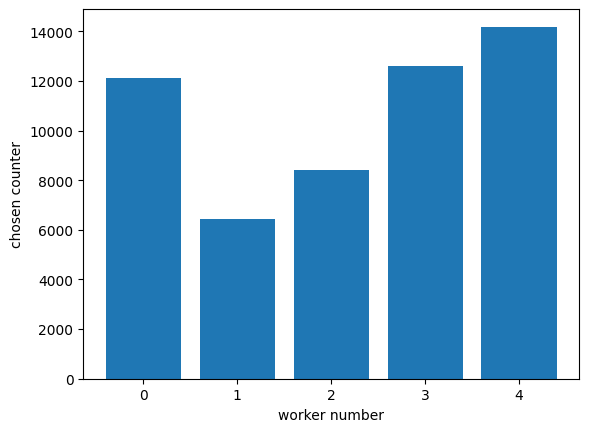

Epoch [86/200] Batch 0/625                     Loss D: 0.1786, loss G: 0.7120, FID Score: 225.0
Epoch [86/200] Batch 100/625                     Loss D: 0.0700, loss G: 0.6835, FID Score: 223.9
Epoch [86/200] Batch 200/625                     Loss D: 0.1528, loss G: 0.5206, FID Score: 225.2
Epoch [86/200] Batch 300/625                     Loss D: 0.0609, loss G: 0.7712, FID Score: 222.8
Epoch [86/200] Batch 400/625                     Loss D: 0.0627, loss G: 0.8508, FID Score: 231.8
Epoch [86/200] Batch 500/625                     Loss D: 0.0863, loss G: 0.6040, FID Score: 216.2
Epoch [86/200] Batch 600/625                     Loss D: 0.1321, loss G: 0.3387, FID Score: 227.6
Epoch [87/200] Batch 0/625                     Loss D: 0.0642, loss G: 0.6295, FID Score: 237.0
Epoch [87/200] Batch 100/625                     Loss D: 0.1072, loss G: 0.5049, FID Score: 219.3
Epoch [87/200] Batch 200/625                     Loss D: 0.1090, loss G: 0.5361, FID Score: 233.1
Epoch [87/200] Batch 300

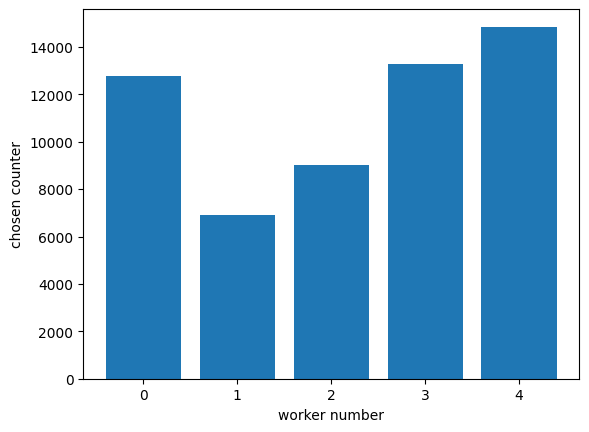

Epoch [91/200] Batch 0/625                     Loss D: 0.0659, loss G: 0.9154, FID Score: 219.6
Epoch [91/200] Batch 100/625                     Loss D: 0.0918, loss G: 0.9518, FID Score: 229.9
Epoch [91/200] Batch 200/625                     Loss D: 0.0526, loss G: 0.7728, FID Score: 231.4
Epoch [91/200] Batch 300/625                     Loss D: 0.0767, loss G: 0.6187, FID Score: 223.7
Epoch [91/200] Batch 400/625                     Loss D: 0.0805, loss G: 0.5448, FID Score: 233.6
Epoch [91/200] Batch 500/625                     Loss D: 0.0834, loss G: 0.7878, FID Score: 234.2
Epoch [91/200] Batch 600/625                     Loss D: 0.1006, loss G: 0.6626, FID Score: 225.7
Epoch [92/200] Batch 0/625                     Loss D: 0.0731, loss G: 0.8605, FID Score: 213.0
Epoch [92/200] Batch 100/625                     Loss D: 0.0856, loss G: 0.6025, FID Score: 223.6
Epoch [92/200] Batch 200/625                     Loss D: 0.0530, loss G: 0.7933, FID Score: 222.1
Epoch [92/200] Batch 300

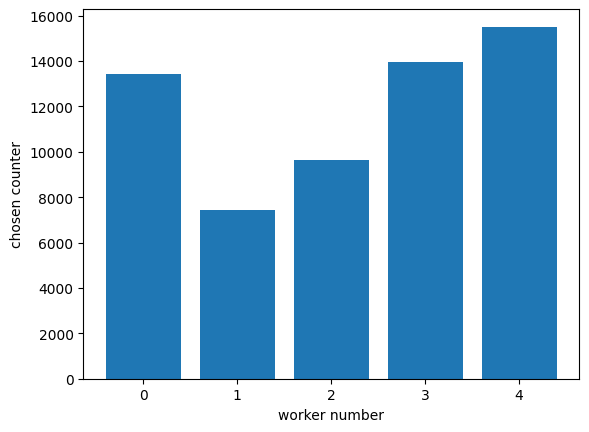

Epoch [96/200] Batch 0/625                     Loss D: 0.0690, loss G: 0.6615, FID Score: 225.5
Epoch [96/200] Batch 100/625                     Loss D: 0.0522, loss G: 0.7546, FID Score: 228.2
Epoch [96/200] Batch 200/625                     Loss D: 0.1535, loss G: 0.4556, FID Score: 218.6
Epoch [96/200] Batch 300/625                     Loss D: 0.0828, loss G: 0.5160, FID Score: 228.6
Epoch [96/200] Batch 400/625                     Loss D: 0.0699, loss G: 0.6736, FID Score: 229.8
Epoch [96/200] Batch 500/625                     Loss D: 0.0694, loss G: 0.6971, FID Score: 232.1
Epoch [96/200] Batch 600/625                     Loss D: 0.0679, loss G: 0.6545, FID Score: 228.2
Epoch [97/200] Batch 0/625                     Loss D: 0.0825, loss G: 0.5619, FID Score: 222.3
Epoch [97/200] Batch 100/625                     Loss D: 0.0540, loss G: 0.7749, FID Score: 234.7
Epoch [97/200] Batch 200/625                     Loss D: 0.0851, loss G: 0.5466, FID Score: 224.1
Epoch [97/200] Batch 300

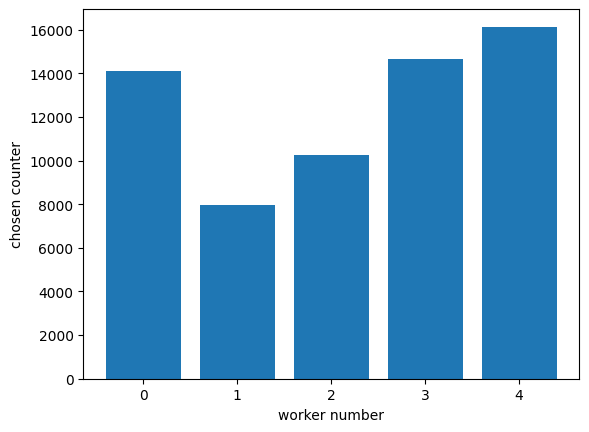

Epoch [101/200] Batch 0/625                     Loss D: 0.0921, loss G: 0.5187, FID Score: 229.0
Epoch [101/200] Batch 100/625                     Loss D: 0.0591, loss G: 0.7547, FID Score: 213.9
Epoch [101/200] Batch 200/625                     Loss D: 0.0455, loss G: 0.9250, FID Score: 217.8
Epoch [101/200] Batch 300/625                     Loss D: 0.0406, loss G: 0.8058, FID Score: 225.4
Epoch [101/200] Batch 400/625                     Loss D: 0.0724, loss G: 0.7196, FID Score: 228.9
Epoch [101/200] Batch 500/625                     Loss D: 0.1696, loss G: 0.6884, FID Score: 225.7
Epoch [101/200] Batch 600/625                     Loss D: 0.0609, loss G: 0.7954, FID Score: 223.8
Epoch [102/200] Batch 0/625                     Loss D: 0.0523, loss G: 0.8821, FID Score: 229.9
Epoch [102/200] Batch 100/625                     Loss D: 0.0461, loss G: 0.8656, FID Score: 220.0
Epoch [102/200] Batch 200/625                     Loss D: 0.0598, loss G: 0.8685, FID Score: 226.8
Epoch [102/200

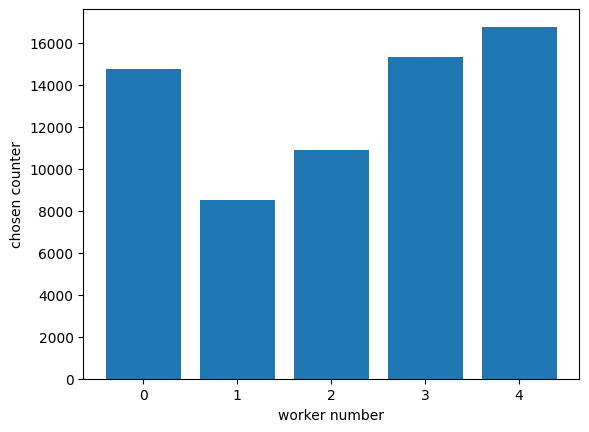

Epoch [106/200] Batch 0/625                     Loss D: 0.1133, loss G: 0.6006, FID Score: 218.5
Epoch [106/200] Batch 100/625                     Loss D: 0.0410, loss G: 0.8690, FID Score: 230.8
Epoch [106/200] Batch 200/625                     Loss D: 0.1036, loss G: 0.6164, FID Score: 232.1
Epoch [106/200] Batch 300/625                     Loss D: 0.0581, loss G: 0.7288, FID Score: 246.6
Epoch [106/200] Batch 400/625                     Loss D: 0.0465, loss G: 0.8652, FID Score: 222.1
Epoch [106/200] Batch 500/625                     Loss D: 0.1314, loss G: 0.5623, FID Score: 233.8
Epoch [106/200] Batch 600/625                     Loss D: 0.0554, loss G: 0.7907, FID Score: 228.9
Epoch [107/200] Batch 0/625                     Loss D: 0.0928, loss G: 0.6785, FID Score: 222.1
Epoch [107/200] Batch 100/625                     Loss D: 0.1494, loss G: 0.4077, FID Score: 221.5
Epoch [107/200] Batch 200/625                     Loss D: 0.0463, loss G: 0.8303, FID Score: 220.7
Epoch [107/200

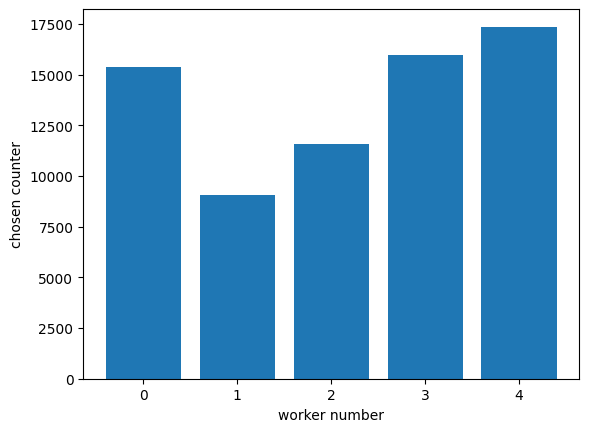

Epoch [111/200] Batch 0/625                     Loss D: 0.0671, loss G: 0.8480, FID Score: 232.0
Epoch [111/200] Batch 100/625                     Loss D: 0.0362, loss G: 0.8316, FID Score: 229.3
Epoch [111/200] Batch 200/625                     Loss D: 0.0343, loss G: 0.8810, FID Score: 238.0
Epoch [111/200] Batch 300/625                     Loss D: 0.0556, loss G: 0.7319, FID Score: 213.3
Epoch [111/200] Batch 400/625                     Loss D: 0.0678, loss G: 0.6678, FID Score: 224.6
Epoch [111/200] Batch 500/625                     Loss D: 0.0301, loss G: 0.8262, FID Score: 246.9
Epoch [111/200] Batch 600/625                     Loss D: 0.0796, loss G: 0.7193, FID Score: 213.4
Epoch [112/200] Batch 0/625                     Loss D: 0.0384, loss G: 0.8053, FID Score: 226.7
Epoch [112/200] Batch 100/625                     Loss D: 0.0452, loss G: 0.7875, FID Score: 220.5
Epoch [112/200] Batch 200/625                     Loss D: 0.0954, loss G: 0.7202, FID Score: 226.7
Epoch [112/200

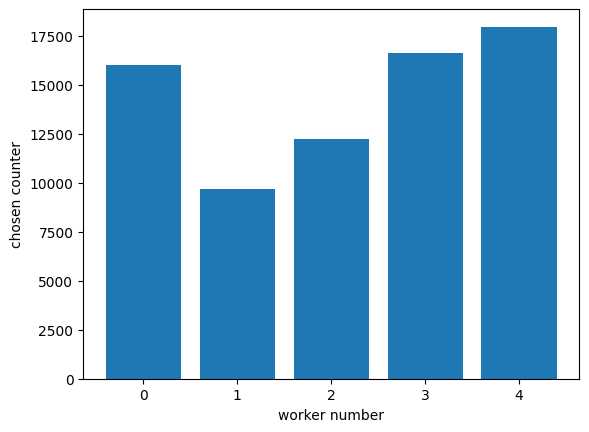

Epoch [116/200] Batch 0/625                     Loss D: 0.0654, loss G: 0.8475, FID Score: 230.6
Epoch [116/200] Batch 100/625                     Loss D: 0.0470, loss G: 0.7496, FID Score: 222.8
Epoch [116/200] Batch 200/625                     Loss D: 0.0406, loss G: 0.8273, FID Score: 239.6
Epoch [116/200] Batch 300/625                     Loss D: 0.0838, loss G: 0.5326, FID Score: 226.1
Epoch [116/200] Batch 400/625                     Loss D: 0.0549, loss G: 0.9063, FID Score: 220.5
Epoch [116/200] Batch 500/625                     Loss D: 0.1196, loss G: 0.6673, FID Score: 227.3
Epoch [116/200] Batch 600/625                     Loss D: 0.0431, loss G: 0.9727, FID Score: 234.4
Epoch [117/200] Batch 0/625                     Loss D: 0.0444, loss G: 0.8380, FID Score: 218.3
Epoch [117/200] Batch 100/625                     Loss D: 0.1002, loss G: 0.5773, FID Score: 220.6
Epoch [117/200] Batch 200/625                     Loss D: 0.1214, loss G: 0.4901, FID Score: 221.7
Epoch [117/200

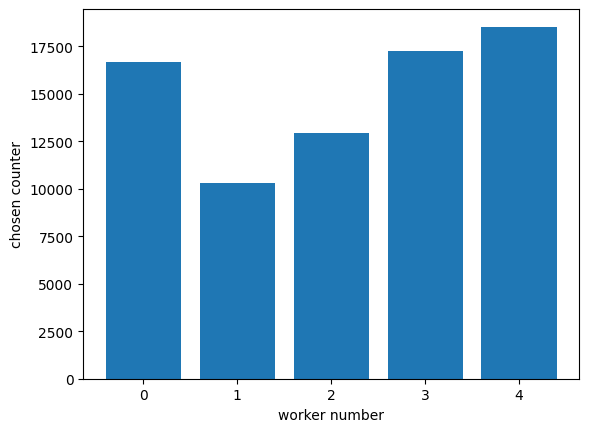

Epoch [121/200] Batch 0/625                     Loss D: 0.0488, loss G: 0.9581, FID Score: 218.5
Epoch [121/200] Batch 100/625                     Loss D: 0.0693, loss G: 0.8404, FID Score: 222.6
Epoch [121/200] Batch 200/625                     Loss D: 0.1326, loss G: 0.5452, FID Score: 227.9
Epoch [121/200] Batch 300/625                     Loss D: 0.0733, loss G: 0.6894, FID Score: 228.9
Epoch [121/200] Batch 400/625                     Loss D: 0.0616, loss G: 0.7178, FID Score: 224.8
Epoch [121/200] Batch 500/625                     Loss D: 0.0579, loss G: 0.8056, FID Score: 218.4
Epoch [121/200] Batch 600/625                     Loss D: 0.1675, loss G: 0.3342, FID Score: 222.5
Epoch [122/200] Batch 0/625                     Loss D: 0.1272, loss G: 0.3870, FID Score: 222.2
Epoch [122/200] Batch 100/625                     Loss D: 0.0397, loss G: 0.8536, FID Score: 239.7
Epoch [122/200] Batch 200/625                     Loss D: 0.0441, loss G: 0.6327, FID Score: 224.7
Epoch [122/200

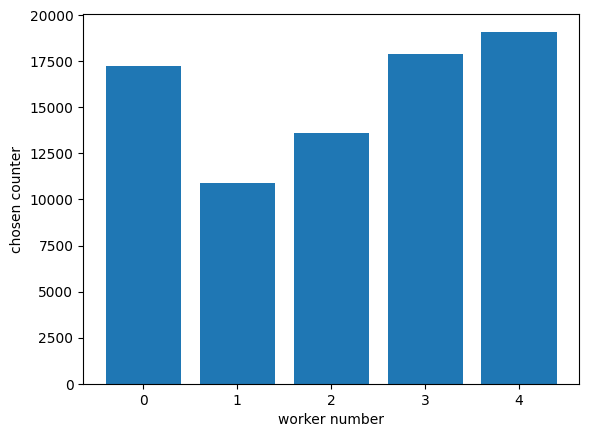

Epoch [126/200] Batch 0/625                     Loss D: 0.0479, loss G: 0.8931, FID Score: 232.0
Epoch [126/200] Batch 100/625                     Loss D: 0.0379, loss G: 0.9020, FID Score: 222.0
Epoch [126/200] Batch 200/625                     Loss D: 0.1085, loss G: 0.5694, FID Score: 221.4
Epoch [126/200] Batch 300/625                     Loss D: 0.0540, loss G: 0.9623, FID Score: 220.1
Epoch [126/200] Batch 400/625                     Loss D: 0.0524, loss G: 0.6754, FID Score: 236.4
Epoch [126/200] Batch 500/625                     Loss D: 0.0867, loss G: 0.5341, FID Score: 218.7
Epoch [126/200] Batch 600/625                     Loss D: 0.0575, loss G: 0.7566, FID Score: 243.7
Epoch [127/200] Batch 0/625                     Loss D: 0.0974, loss G: 0.6318, FID Score: 225.4
Epoch [127/200] Batch 100/625                     Loss D: 0.0603, loss G: 0.7415, FID Score: 236.1
Epoch [127/200] Batch 200/625                     Loss D: 0.1011, loss G: 0.6433, FID Score: 232.7
Epoch [127/200

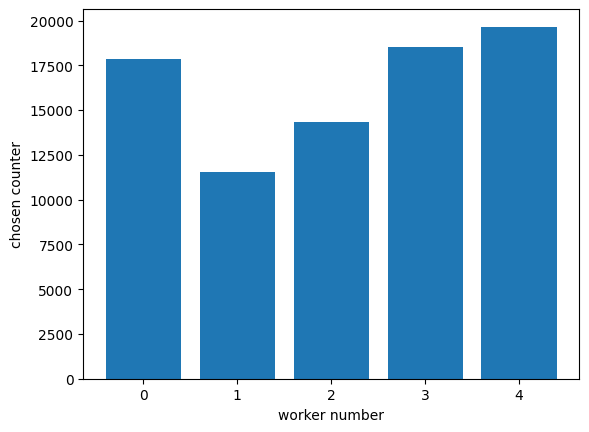

Epoch [131/200] Batch 0/625                     Loss D: 0.0690, loss G: 0.8457, FID Score: 224.1
Epoch [131/200] Batch 100/625                     Loss D: 0.0413, loss G: 0.8430, FID Score: 239.2
Epoch [131/200] Batch 200/625                     Loss D: 0.0339, loss G: 0.7878, FID Score: 227.6
Epoch [131/200] Batch 300/625                     Loss D: 0.0736, loss G: 0.6391, FID Score: 231.4
Epoch [131/200] Batch 400/625                     Loss D: 0.0690, loss G: 0.7708, FID Score: 223.1
Epoch [131/200] Batch 500/625                     Loss D: 0.0968, loss G: 0.6750, FID Score: 219.4
Epoch [131/200] Batch 600/625                     Loss D: 0.0455, loss G: 0.9132, FID Score: 230.7
Epoch [132/200] Batch 0/625                     Loss D: 0.0455, loss G: 0.7920, FID Score: 224.4
Epoch [132/200] Batch 100/625                     Loss D: 0.0778, loss G: 0.9698, FID Score: 232.4
Epoch [132/200] Batch 200/625                     Loss D: 0.0518, loss G: 0.6459, FID Score: 224.1
Epoch [132/200

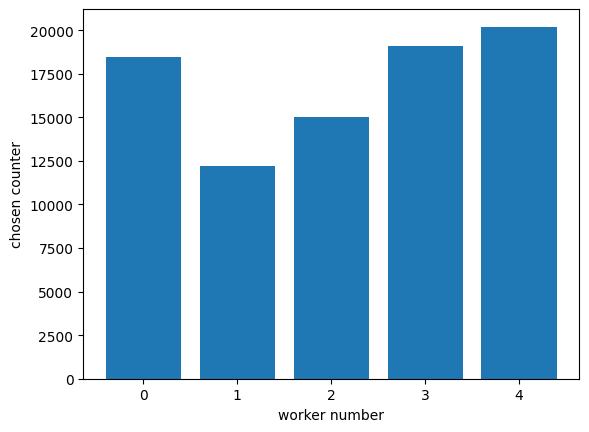

Epoch [136/200] Batch 0/625                     Loss D: 0.1144, loss G: 0.4783, FID Score: 212.1
Epoch [136/200] Batch 100/625                     Loss D: 0.0814, loss G: 0.6958, FID Score: 222.0
Epoch [136/200] Batch 200/625                     Loss D: 0.0832, loss G: 0.6813, FID Score: 217.4
Epoch [136/200] Batch 300/625                     Loss D: 0.0453, loss G: 0.7190, FID Score: 223.0
Epoch [136/200] Batch 400/625                     Loss D: 0.0383, loss G: 0.8802, FID Score: 212.4
Epoch [136/200] Batch 500/625                     Loss D: 0.0351, loss G: 0.9322, FID Score: 233.6
Epoch [136/200] Batch 600/625                     Loss D: 0.2323, loss G: 0.2952, FID Score: 233.3
Epoch [137/200] Batch 0/625                     Loss D: 0.1158, loss G: 0.4310, FID Score: 230.1
Epoch [137/200] Batch 100/625                     Loss D: 0.0737, loss G: 0.6823, FID Score: 238.9
Epoch [137/200] Batch 200/625                     Loss D: 0.0369, loss G: 0.8238, FID Score: 218.6
Epoch [137/200

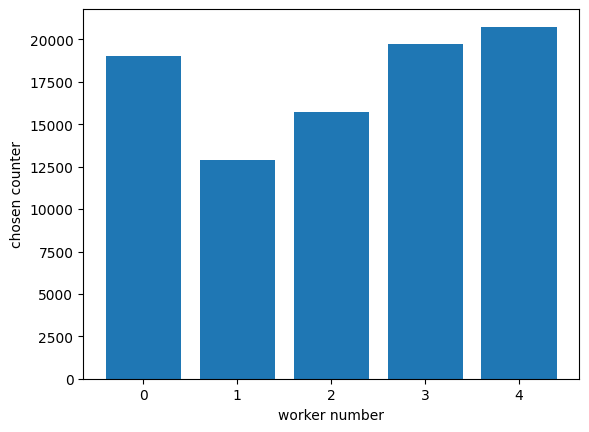

Epoch [141/200] Batch 0/625                     Loss D: 0.0338, loss G: 0.9145, FID Score: 227.8
Epoch [141/200] Batch 100/625                     Loss D: 0.0974, loss G: 0.3972, FID Score: 229.6
Epoch [141/200] Batch 200/625                     Loss D: 0.1495, loss G: 0.6298, FID Score: 235.1
Epoch [141/200] Batch 300/625                     Loss D: 0.0419, loss G: 0.7176, FID Score: 220.2
Epoch [141/200] Batch 400/625                     Loss D: 0.0414, loss G: 0.9040, FID Score: 214.1
Epoch [141/200] Batch 500/625                     Loss D: 0.0820, loss G: 0.5943, FID Score: 231.4
Epoch [141/200] Batch 600/625                     Loss D: 0.0394, loss G: 0.9556, FID Score: 227.0
Epoch [142/200] Batch 0/625                     Loss D: 0.0320, loss G: 0.8808, FID Score: 219.1
Epoch [142/200] Batch 100/625                     Loss D: 0.0574, loss G: 0.6437, FID Score: 213.8
Epoch [142/200] Batch 200/625                     Loss D: 0.0170, loss G: 0.9810, FID Score: 220.1
Epoch [142/200

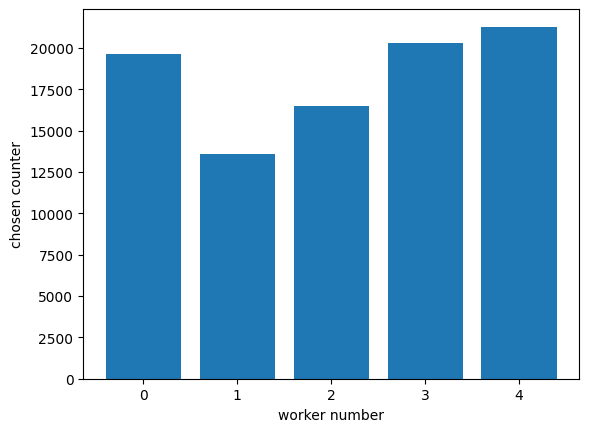

Epoch [146/200] Batch 0/625                     Loss D: 0.1339, loss G: 0.3979, FID Score: 227.7
Epoch [146/200] Batch 100/625                     Loss D: 0.0457, loss G: 0.7821, FID Score: 230.6
Epoch [146/200] Batch 200/625                     Loss D: 0.0315, loss G: 0.8561, FID Score: 221.4
Epoch [146/200] Batch 300/625                     Loss D: 0.0517, loss G: 0.7668, FID Score: 225.5
Epoch [146/200] Batch 400/625                     Loss D: 0.0822, loss G: 0.5071, FID Score: 229.3
Epoch [146/200] Batch 500/625                     Loss D: 0.0372, loss G: 0.9408, FID Score: 229.5
Epoch [146/200] Batch 600/625                     Loss D: 0.0321, loss G: 0.8774, FID Score: 225.1
Epoch [147/200] Batch 0/625                     Loss D: 0.0704, loss G: 0.5050, FID Score: 232.4
Epoch [147/200] Batch 100/625                     Loss D: 0.0249, loss G: 0.9338, FID Score: 220.6
Epoch [147/200] Batch 200/625                     Loss D: 0.0371, loss G: 0.8899, FID Score: 221.6
Epoch [147/200

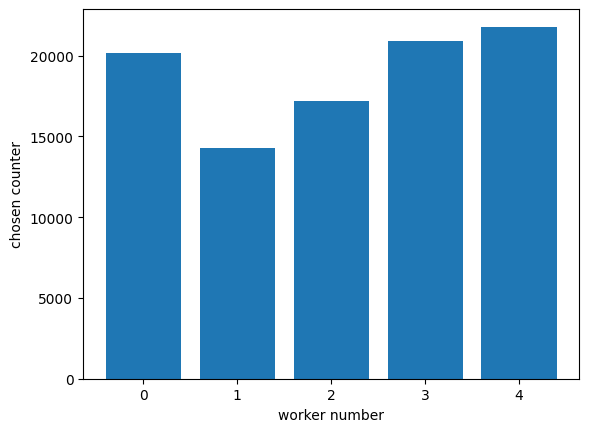

Epoch [151/200] Batch 0/625                     Loss D: 0.0486, loss G: 0.9135, FID Score: 221.3
Epoch [151/200] Batch 100/625                     Loss D: 0.0276, loss G: 0.8688, FID Score: 234.0
Epoch [151/200] Batch 200/625                     Loss D: 0.0208, loss G: 1.0499, FID Score: 221.2
Epoch [151/200] Batch 300/625                     Loss D: 0.0597, loss G: 0.8340, FID Score: 216.8
Epoch [151/200] Batch 400/625                     Loss D: 0.0297, loss G: 0.8462, FID Score: 227.7
Epoch [151/200] Batch 500/625                     Loss D: 0.0748, loss G: 0.6746, FID Score: 222.6
Epoch [151/200] Batch 600/625                     Loss D: 0.0302, loss G: 0.8688, FID Score: 217.2
Epoch [152/200] Batch 0/625                     Loss D: 0.0247, loss G: 0.8734, FID Score: 239.8
Epoch [152/200] Batch 100/625                     Loss D: 0.0671, loss G: 0.6202, FID Score: 234.6
Epoch [152/200] Batch 200/625                     Loss D: 0.0494, loss G: 0.7152, FID Score: 235.2
Epoch [152/200

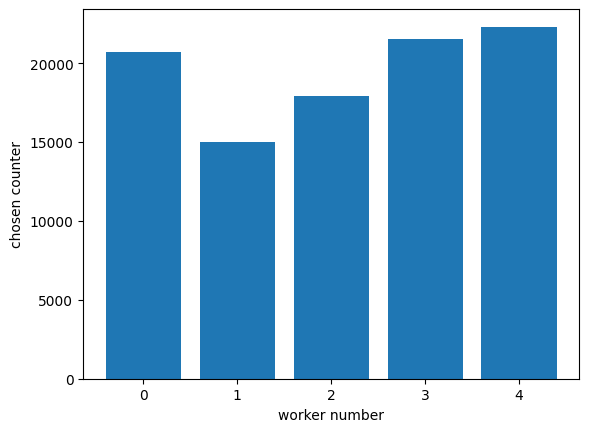

Epoch [156/200] Batch 0/625                     Loss D: 0.0439, loss G: 0.8233, FID Score: 237.3
Epoch [156/200] Batch 100/625                     Loss D: 0.0248, loss G: 0.9095, FID Score: 221.7
Epoch [156/200] Batch 200/625                     Loss D: 0.0324, loss G: 0.9290, FID Score: 231.8
Epoch [156/200] Batch 300/625                     Loss D: 0.0374, loss G: 0.9867, FID Score: 229.1
Epoch [156/200] Batch 400/625                     Loss D: 0.0274, loss G: 0.9014, FID Score: 219.2
Epoch [156/200] Batch 500/625                     Loss D: 0.0286, loss G: 0.9102, FID Score: 226.1
Epoch [156/200] Batch 600/625                     Loss D: 0.0366, loss G: 0.8803, FID Score: 237.0
Epoch [157/200] Batch 0/625                     Loss D: 0.0877, loss G: 0.7095, FID Score: 228.9
Epoch [157/200] Batch 100/625                     Loss D: 0.0801, loss G: 0.5258, FID Score: 224.3
Epoch [157/200] Batch 200/625                     Loss D: 0.0474, loss G: 1.0600, FID Score: 226.4
Epoch [157/200

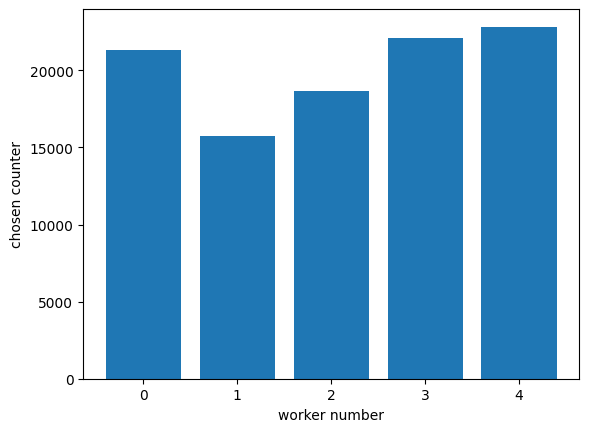

Epoch [161/200] Batch 0/625                     Loss D: 0.1033, loss G: 0.7103, FID Score: 226.9
Epoch [161/200] Batch 100/625                     Loss D: 0.0274, loss G: 0.9124, FID Score: 236.4
Epoch [161/200] Batch 200/625                     Loss D: 0.0463, loss G: 0.7079, FID Score: 219.4
Epoch [161/200] Batch 300/625                     Loss D: 0.0365, loss G: 0.8915, FID Score: 220.3
Epoch [161/200] Batch 400/625                     Loss D: 0.0616, loss G: 0.7443, FID Score: 238.3
Epoch [161/200] Batch 500/625                     Loss D: 0.0352, loss G: 0.8944, FID Score: 223.4
Epoch [161/200] Batch 600/625                     Loss D: 0.0530, loss G: 0.8091, FID Score: 217.7
Epoch [162/200] Batch 0/625                     Loss D: 0.0358, loss G: 0.9211, FID Score: 227.8
Epoch [162/200] Batch 100/625                     Loss D: 0.0210, loss G: 0.9967, FID Score: 213.3
Epoch [162/200] Batch 200/625                     Loss D: 0.0379, loss G: 0.8294, FID Score: 225.6
Epoch [162/200

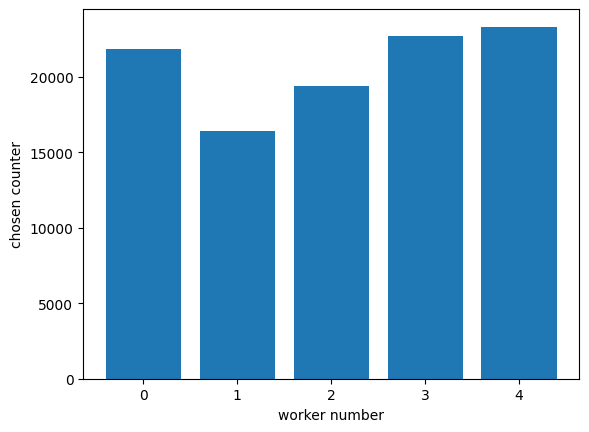

Epoch [166/200] Batch 0/625                     Loss D: 0.0425, loss G: 0.7739, FID Score: 236.9
Epoch [166/200] Batch 100/625                     Loss D: 0.0379, loss G: 0.8752, FID Score: 226.6
Epoch [166/200] Batch 200/625                     Loss D: 0.0352, loss G: 0.7830, FID Score: 230.6
Epoch [166/200] Batch 300/625                     Loss D: 0.0268, loss G: 0.7575, FID Score: 216.3
Epoch [166/200] Batch 400/625                     Loss D: 0.0333, loss G: 0.8998, FID Score: 228.4
Epoch [166/200] Batch 500/625                     Loss D: 0.0277, loss G: 0.9569, FID Score: 221.3
Epoch [166/200] Batch 600/625                     Loss D: 0.0260, loss G: 0.8875, FID Score: 224.6
Epoch [167/200] Batch 0/625                     Loss D: 0.0478, loss G: 0.7429, FID Score: 220.3
Epoch [167/200] Batch 100/625                     Loss D: 0.1120, loss G: 0.4618, FID Score: 216.6
Epoch [167/200] Batch 200/625                     Loss D: 0.0443, loss G: 0.7759, FID Score: 228.3
Epoch [167/200

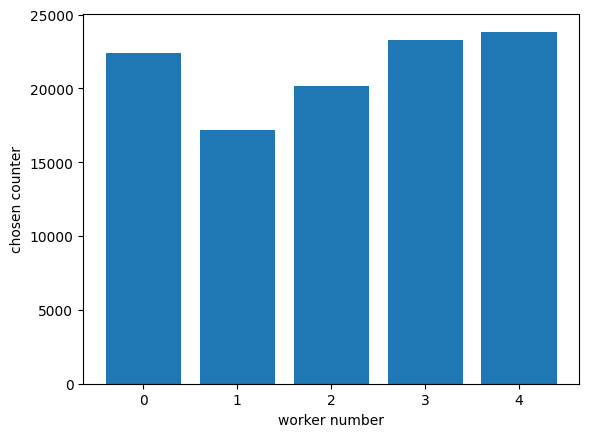

Epoch [171/200] Batch 0/625                     Loss D: 0.0343, loss G: 0.9014, FID Score: 228.3
Epoch [171/200] Batch 100/625                     Loss D: 0.0379, loss G: 0.8653, FID Score: 218.4
Epoch [171/200] Batch 200/625                     Loss D: 0.0268, loss G: 0.8812, FID Score: 223.9
Epoch [171/200] Batch 300/625                     Loss D: 0.0597, loss G: 0.7755, FID Score: 219.4
Epoch [171/200] Batch 400/625                     Loss D: 0.0426, loss G: 1.0553, FID Score: 225.0
Epoch [171/200] Batch 500/625                     Loss D: 0.0501, loss G: 0.6494, FID Score: 226.4
Epoch [171/200] Batch 600/625                     Loss D: 0.0260, loss G: 0.9146, FID Score: 231.0
Epoch [172/200] Batch 0/625                     Loss D: 0.0376, loss G: 0.8677, FID Score: 247.2
Epoch [172/200] Batch 100/625                     Loss D: 0.0352, loss G: 0.8901, FID Score: 227.5
Epoch [172/200] Batch 200/625                     Loss D: 0.0272, loss G: 0.8995, FID Score: 227.3
Epoch [172/200

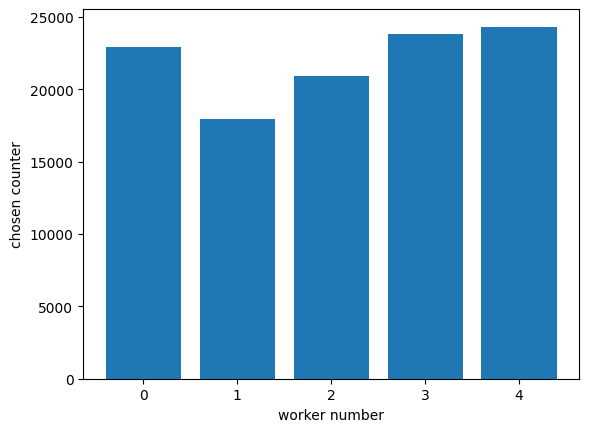

Epoch [176/200] Batch 0/625                     Loss D: 0.0278, loss G: 0.9201, FID Score: 229.6
Epoch [176/200] Batch 100/625                     Loss D: 0.0216, loss G: 0.9534, FID Score: 222.5
Epoch [176/200] Batch 200/625                     Loss D: 0.0382, loss G: 0.8869, FID Score: 223.7
Epoch [176/200] Batch 300/625                     Loss D: 0.0498, loss G: 0.6031, FID Score: 232.7
Epoch [176/200] Batch 400/625                     Loss D: 0.0265, loss G: 0.8310, FID Score: 215.3
Epoch [176/200] Batch 500/625                     Loss D: 0.1498, loss G: 0.2478, FID Score: 226.5
Epoch [176/200] Batch 600/625                     Loss D: 0.0376, loss G: 0.9055, FID Score: 209.5
Epoch [177/200] Batch 0/625                     Loss D: 0.0338, loss G: 0.8607, FID Score: 223.4
Epoch [177/200] Batch 100/625                     Loss D: 0.0471, loss G: 0.9736, FID Score: 227.5
Epoch [177/200] Batch 200/625                     Loss D: 0.1196, loss G: 0.4152, FID Score: 234.0
Epoch [177/200

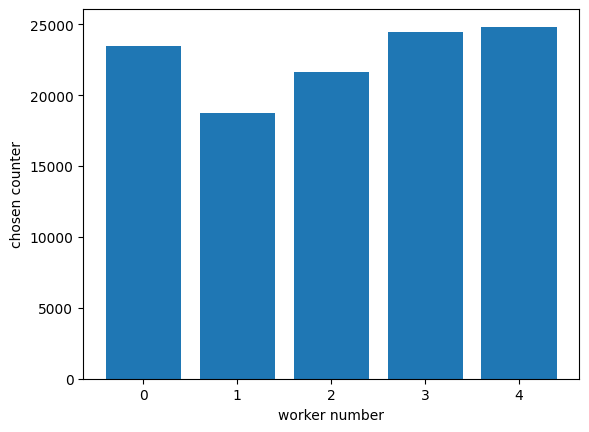

Epoch [181/200] Batch 0/625                     Loss D: 0.1245, loss G: 0.4745, FID Score: 234.2
Epoch [181/200] Batch 100/625                     Loss D: 0.1499, loss G: 0.4446, FID Score: 239.1
Epoch [181/200] Batch 200/625                     Loss D: 0.0368, loss G: 0.9167, FID Score: 226.1
Epoch [181/200] Batch 300/625                     Loss D: 0.0346, loss G: 0.9334, FID Score: 225.0
Epoch [181/200] Batch 400/625                     Loss D: 0.0268, loss G: 0.9662, FID Score: 228.9
Epoch [181/200] Batch 500/625                     Loss D: 0.0305, loss G: 0.8709, FID Score: 225.6
Epoch [181/200] Batch 600/625                     Loss D: 0.1192, loss G: 0.5227, FID Score: 230.0
Epoch [182/200] Batch 0/625                     Loss D: 0.0433, loss G: 0.8244, FID Score: 237.6
Epoch [182/200] Batch 100/625                     Loss D: 0.0374, loss G: 0.8894, FID Score: 235.6
Epoch [182/200] Batch 200/625                     Loss D: 0.0284, loss G: 0.8769, FID Score: 233.9
Epoch [182/200

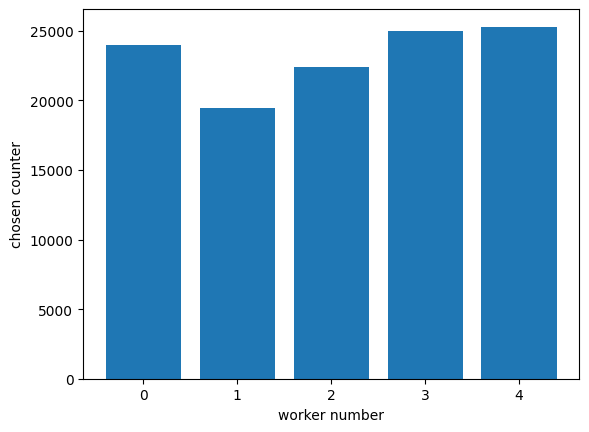

Epoch [186/200] Batch 0/625                     Loss D: 0.0243, loss G: 0.8562, FID Score: 229.6
Epoch [186/200] Batch 100/625                     Loss D: 0.0227, loss G: 0.9996, FID Score: 260.5
Epoch [186/200] Batch 200/625                     Loss D: 0.1564, loss G: 0.5075, FID Score: 229.6
Epoch [186/200] Batch 300/625                     Loss D: 0.0308, loss G: 0.8198, FID Score: 219.8
Epoch [186/200] Batch 400/625                     Loss D: 0.0376, loss G: 0.9046, FID Score: 229.8
Epoch [186/200] Batch 500/625                     Loss D: 0.0400, loss G: 0.8782, FID Score: 235.4
Epoch [186/200] Batch 600/625                     Loss D: 0.0282, loss G: 0.8690, FID Score: 218.8
Epoch [187/200] Batch 0/625                     Loss D: 0.0198, loss G: 0.9745, FID Score: 229.5
Epoch [187/200] Batch 100/625                     Loss D: 0.0319, loss G: 0.9297, FID Score: 226.8
Epoch [187/200] Batch 200/625                     Loss D: 0.0190, loss G: 0.9384, FID Score: 227.4
Epoch [187/200

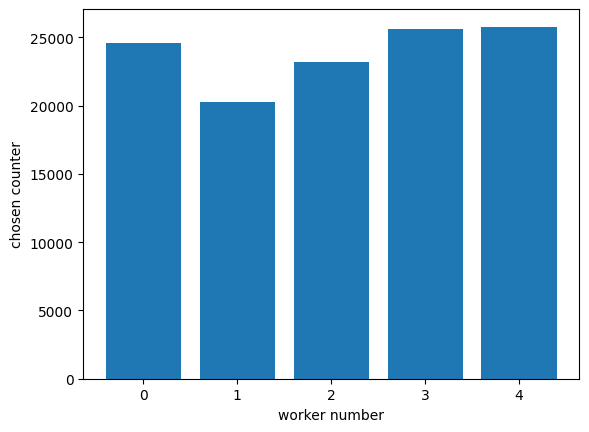

Epoch [191/200] Batch 0/625                     Loss D: 0.0558, loss G: 0.8540, FID Score: 223.9
Epoch [191/200] Batch 100/625                     Loss D: 0.0218, loss G: 0.9075, FID Score: 217.2
Epoch [191/200] Batch 200/625                     Loss D: 0.0190, loss G: 0.9588, FID Score: 216.1
Epoch [191/200] Batch 300/625                     Loss D: 0.0420, loss G: 0.8397, FID Score: 222.2
Epoch [191/200] Batch 400/625                     Loss D: 0.0225, loss G: 0.8657, FID Score: 229.2
Epoch [191/200] Batch 500/625                     Loss D: 0.0348, loss G: 0.8668, FID Score: 219.0
Epoch [191/200] Batch 600/625                     Loss D: 0.1219, loss G: 0.5520, FID Score: 249.7
Epoch [192/200] Batch 0/625                     Loss D: 0.0247, loss G: 0.9275, FID Score: 222.0
Epoch [192/200] Batch 100/625                     Loss D: 0.0362, loss G: 0.8687, FID Score: 243.9
Epoch [192/200] Batch 200/625                     Loss D: 0.0504, loss G: 0.5658, FID Score: 219.3
Epoch [192/200

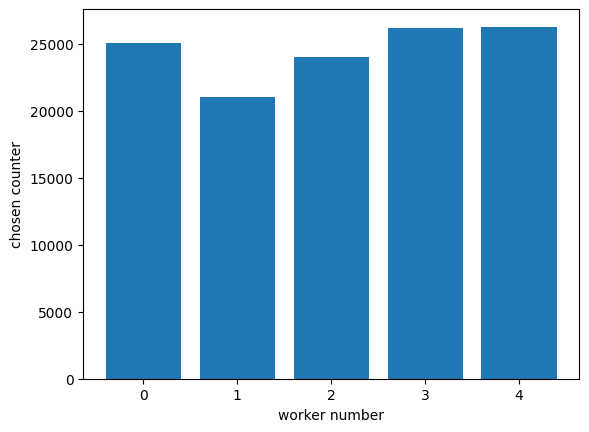

Epoch [196/200] Batch 0/625                     Loss D: 0.0877, loss G: 0.6603, FID Score: 213.7
Epoch [196/200] Batch 100/625                     Loss D: 0.0269, loss G: 0.9018, FID Score: 224.2
Epoch [196/200] Batch 200/625                     Loss D: 0.0279, loss G: 0.9885, FID Score: 217.1
Epoch [196/200] Batch 300/625                     Loss D: 0.0354, loss G: 0.8017, FID Score: 220.4
Epoch [196/200] Batch 400/625                     Loss D: 0.0461, loss G: 0.8261, FID Score: 221.6
Epoch [196/200] Batch 500/625                     Loss D: 0.0324, loss G: 0.8861, FID Score: 218.2
Epoch [196/200] Batch 600/625                     Loss D: 0.1134, loss G: 0.4329, FID Score: 216.8
Epoch [197/200] Batch 0/625                     Loss D: 0.0295, loss G: 0.9747, FID Score: 224.0
Epoch [197/200] Batch 100/625                     Loss D: 0.0876, loss G: 0.4262, FID Score: 216.3
Epoch [197/200] Batch 200/625                     Loss D: 0.0381, loss G: 0.8077, FID Score: 229.3
Epoch [197/200

In [42]:
# main training loop for F2U (trial == FALSE)
if not trial:
    start = 0
    end = start + NUM_EPOCHS

    worker_chosen_counter = [0 for i in range(len(workers))]

    for epoch in range(start,end):
        for batch_id in range(len(worker_loaders[0])):

            highest_loss = 0
            lowest_loss = math.inf
            chosen_discriminator = None
            noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
            fake = main_server.generator(noise)

            for worker_id, worker in enumerate(workers):
                current_worker_real = worker_loaders[worker_id][batch_id].float().to(dev)
                # print(real.shape)

                ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
                current_disc_real = worker.discriminator(current_worker_real).reshape(-1)
                worker.loss_disc_real = criterion(current_disc_real, torch.ones_like(current_disc_real))
                current_disc_fake = worker.discriminator(fake.detach()).reshape(-1)
                worker.loss_disc_fake = criterion(current_disc_fake, torch.zeros_like(current_disc_fake))
                worker.loss_disc = (worker.loss_disc_real + worker.loss_disc_fake) / 2
                worker.discriminator.zero_grad()
                worker.loss_disc.backward()
                worker.d_optimizer.step()
                # print(worker.loss_disc_fake, i)
                # if highest_loss < worker.loss_disc_fake:
                #     highest_loss = worker.loss_disc_fake
                #     chosen_discriminator = worker_id
                if lowest_loss > worker.loss_disc_fake:
                    lowest_loss = worker.loss_disc_fake
                    chosen_discriminator = worker_id
            # print(f"chosen worker is {chosen_discriminator} with loss of: {highest_loss.item():.4f}")
            chosen_worker = workers[chosen_discriminator]
            worker_chosen_counter[chosen_discriminator]+=1
            

            ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
            output = chosen_worker.discriminator(fake).reshape(-1)
            main_server.loss_gen = criterion(output, torch.ones_like(output))
            main_server.generator.zero_grad()
            main_server.loss_gen.backward()
            main_server.g_optimizer.step()

            logger.log(chosen_worker.loss_disc.item(),main_server.loss_gen.item(),chosen_worker.loss_disc_real, chosen_worker.loss_disc_fake,epoch,batch_id,len(worker_loaders[0]))

            # Print loss
            if batch_id % 100 == 0:
                fid_z = torch.randn(FID_BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
                gen_imgs = main_server.generator(fid_z.detach())
                mu_gen, sigma_gen = calculate_activation_statistics(gen_imgs, fic_model, batch_size=FID_BATCH_SIZE,cuda=True)
                mu_test, sigma_test = calculate_activation_statistics(test_imgs[:FID_BATCH_SIZE], fic_model, batch_size=FID_BATCH_SIZE)
                fid = calculate_frechet_distance(mu_gen, sigma_gen, mu_test, sigma_test)
                logger.log_fid(fid,epoch,batch_id,len(worker_loaders[0]))

                print(
                    f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_id}/{len(worker_loaders[0])} \
                    Loss D: {chosen_worker.loss_disc:.4f}, loss G: {main_server.loss_gen:.4f}, FID Score: {fid:.1f}"
                )
            
        with torch.no_grad():
            fake = main_server.generator(fixed_noise)
            logger.log_images(fake,len(fake), epoch, batch_id, len(worker_loaders[0]))

        if epoch % 5 == 0 and epoch != 0:
            plt.bar(range(len(worker_chosen_counter)),worker_chosen_counter)
            plt.xlabel('worker number')
            plt.ylabel('chosen counter')
            plt.show()
        if epoch % 20 == 0 and epoch != 0:
            logger.save_models(main_server,workers,epoch)

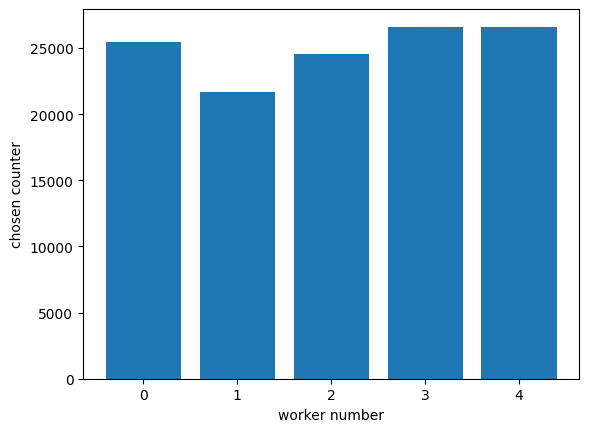

In [43]:
plt.bar(range(len(worker_chosen_counter)),worker_chosen_counter)
plt.xlabel('worker number')
plt.ylabel('chosen counter')
plt.show()